<a id='home'></a>

# Modelo de crédito para pessoa física

## Conteúdo

- [Análise exploratória dos dados](#explora)
- [Pré-processamento, limpeza, e remoção de dados](#dataprep)
- [Modelos de classificação](#modelo)
  - [Multinomial naive bayes](#texto)
  - [Gaussian naive bayes](#numer)
  - [Árvore de decisão](#categ)
  - [Stacking de modelos](#stack)
- [Avaliação da solução](#avalia)
- [Importância das variáveis](#importance)

<a id='explora'></a>

## Análise exploratória dos dados

[topo](#home)

In [1]:
import sys

sys.path.append('../python')

In [2]:
%matplotlib inline

from dataprep import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
dataset = pd.read_csv('../dados/dataset.csv') \
    .drop_duplicates()

dataset.head(3)

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,NaN,10000.0,NaN,NaN,NaN,NaN,0,...,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.0,23936.0,Muriaé,MG,NaN,1.0,0,...,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.0,2600.0,18000.0,5000.0,Araxá,MG,10000.0,0.0,0,...,0.0,1.0,0.0,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN


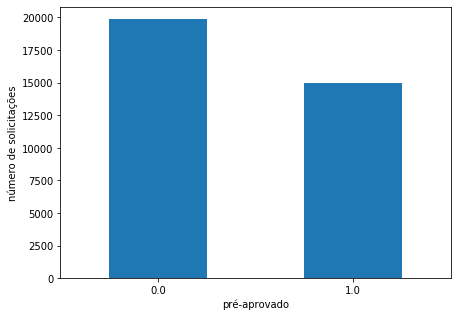

In [4]:
pre_aprovados = dataset.pre_approved.value_counts()

pre_aprovados.plot.bar(rot=0, figsize=(7, 5))

plt.ylabel('número de solicitações')
plt.xlabel('pré-aprovado');

In [5]:
print('Solicitações pré-aprovadas:', pre_aprovados[1])

Solicitações pré-aprovadas: 14998


<a id='dataprep'></a>

## Pré-processamento, limpeza, e remoção de dados

[topo](#home)

In [6]:
publico = dataprep(dataset)

In [7]:
""" Sumário do pré-processamento
"""

print(f'   {"coluna":>25} {"tipo":>10} {"unicos":>10} {"nulos":>10}')
      
for i, col in enumerate(publico.columns):
    col_dtype = str(publico[col].dtype)
    col_count = publico[col].nunique()
    col_nulos = publico[col].isna().sum()
    print(f'{i+1:>2} {col:>25} {col_dtype:>10} {col_count:>10} {col_nulos:>10}')

                      coluna       tipo     unicos      nulos
 1                        id      int64      13290          0
 2                       age    float64         56          0
 3            monthly_income    float64       1303          0
 4               loan_amount    float64        926          0
 5                      city      int64       2099          0
 6                     state      int64         27          0
 7         dishonored_checks      int64          2          0
 8             banking_debts      int64          2          0
 9          commercial_debts      int64          2          0
10                  protests      int64          2          0
11      informed_restriction      int64          3          0
12           monthly_payment    float64       2162          0
13          informed_purpose     object       8091          0
14                auto_brand      int64         49          0
15                auto_model      int64       1552          0
16      

In [8]:
publico.shape

(13290, 24)

<a id='modelo'></a>

## Modelos de classificação

[topo](#home)

In [9]:
""" Amostras de treino, teste e validação
"""

target = 'sent_to_analysis'

y = publico[target]
X = publico.drop(target, axis=1)

X_train, X_teste, y_train, y_teste = train_test_split(
    X, y, test_size=0.5, random_state=42)

X_teste, X_valid, y_teste, y_valid = train_test_split(
    X_teste, y_teste, test_size=0.5, random_state=42)

print('train:', X_train.shape)
print('teste:', X_teste.shape)
print('valid:', X_valid.shape)

train: (6645, 23)
teste: (3322, 23)
valid: (3323, 23)


<a id='texto'></a>

### Multinomial naive bayes

[topo](#home)

In [10]:
%%time

X_train_obj = X_train.informed_purpose
X_teste_obj = X_teste.informed_purpose
X_valid_obj = X_valid.informed_purpose

vectorizer = bag_of_words(X_train_obj)

X_train_vec = vectorizer.transform(X_train_obj)
X_teste_vec = vectorizer.transform(X_teste_obj)
X_valid_vec = vectorizer.transform(X_valid_obj)

CPU times: user 688 ms, sys: 8.61 ms, total: 697 ms
Wall time: 696 ms


In [11]:
%%time

mnb = MultinomialNB()

mnb.fit(X_train_vec, y_train)

mnb_score_teste = mnb.predict_proba(X_teste_vec)[:, 1]
mnb_score_valid = mnb.predict_proba(X_valid_vec)[:, 1]

CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 3.43 ms


<a id='numer'></a>

### Gaussian naive bayes

[topo](#home)

In [12]:
X_train_num = X_train.select_dtypes(include=['float64'])
X_teste_num = X_teste.select_dtypes(include=['float64'])
X_valid_num = X_valid.select_dtypes(include=['float64'])

In [13]:
scaler = StandardScaler()

scaler.fit(X_train_num)

X_train_num_norm = scaler.transform(X_train_num)
X_teste_num_norm = scaler.transform(X_teste_num)
X_valid_num_norm = scaler.transform(X_valid_num)

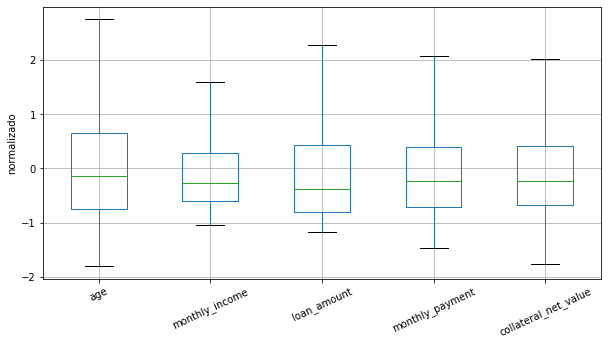

In [14]:
df = pd.DataFrame(X_train_num_norm)
df.columns = X_train_num.columns

df.boxplot(rot=25, showfliers=False, figsize=(10, 5))

plt.ylabel('normalizado');

In [15]:
%%time

gnb = GaussianNB()

gnb.fit(X_train_num_norm, y_train)

gnb_score_teste = gnb.predict_proba(X_teste_num_norm)[:, 1]
gnb_score_valid = gnb.predict_proba(X_valid_num_norm)[:, 1]

CPU times: user 4.22 ms, sys: 67 µs, total: 4.29 ms
Wall time: 4.05 ms


<a id='categ'></a>

### Árvore de decisão

[topo](#home)

In [16]:
X_train_cat = X_train.select_dtypes(include=['int64'])
X_teste_cat = X_teste.select_dtypes(include=['int64'])
X_valid_cat = X_valid.select_dtypes(include=['int64'])

In [17]:
%%time

parameters = {
    'class_weight': ('balanced', None)
}

dtr = GridSearchCV(
    DecisionTreeClassifier(
        max_depth=4,
        random_state=42
    ),
    parameters,
    cv=2
)

dtr.fit(X_train_cat, y_train)

dtr_score_teste = dtr.predict_proba(X_teste_cat)[:, 1]
dtr_score_valid = dtr.predict_proba(X_valid_cat)[:, 1]

CPU times: user 53.1 ms, sys: 110 µs, total: 53.3 ms
Wall time: 52.6 ms


<a id='stack'></a>

### Stacking de modelos

[topo](#home)

In [18]:
X_teste_stack = np.c_[mnb_score_teste, gnb_score_teste, dtr_score_teste]
X_valid_stack = np.c_[mnb_score_valid, gnb_score_valid, dtr_score_valid]

In [19]:
%%time

clf = LogisticRegression(random_state=42, solver='lbfgs')

clf.fit(X_teste_stack, y_teste)

clf_score_valid = clf.predict_proba(X_valid_stack)[:, 1]

CPU times: user 34 ms, sys: 28.6 ms, total: 62.6 ms
Wall time: 9.98 ms


<a id='avalia'></a>

## Avaliação da solução

[topo](#home)

In [20]:
mnb_auc = roc_auc_score(y_valid, mnb_score_valid)
gnb_auc = roc_auc_score(y_valid, gnb_score_valid)
dtr_auc = roc_auc_score(y_valid, dtr_score_valid)
clf_auc = roc_auc_score(y_valid, clf_score_valid)

print('Multinomial Naive Bayes:', mnb_auc)
print('Gaussian Naive Bayes:', gnb_auc)
print('Decision Tree:', dtr_auc)
print('Stacking:', clf_auc)

Multinomial Naive Bayes: 0.635173980759247
Gaussian Naive Bayes: 0.6413231809840002
Decision Tree: 0.7237944619276218
Stacking: 0.7620933024831809


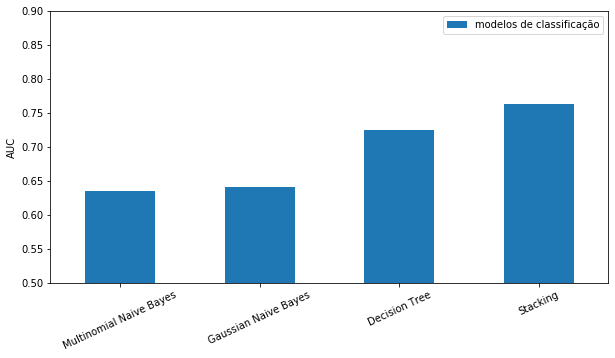

In [21]:
df = pd.DataFrame(
    data=[mnb_auc, gnb_auc, dtr_auc, clf_auc],
    index=[
        'Multinomial Naive Bayes',
        'Gaussian Naive Bayes',
        'Decision Tree',
        'Stacking'
    ],
    columns=['modelos de classificação']
)

df.plot.bar(rot=25, figsize=(10, 5))
plt.ylim(0.5, 0.9)
plt.ylabel('AUC');

<a id='importance'></a>

## Importância das variáveis

[topo](#home)

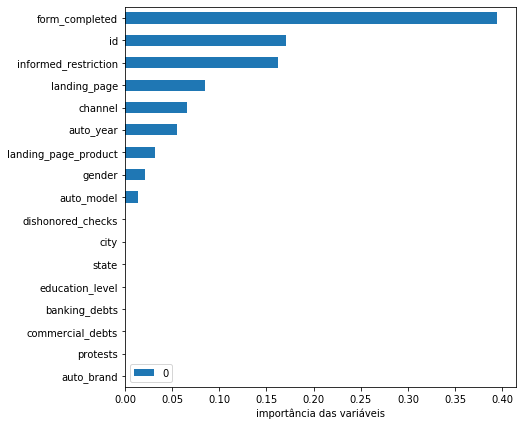

In [22]:
df = pd.DataFrame(
    data=dtr.best_estimator_.feature_importances_,
    index=X_train_cat.columns
).sort_values(by=0)

df.plot.barh(figsize=(7, 7))
plt.xlabel('importância das variáveis');